In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
# from brokenaxes import brokenaxes
#from scipy.stats.mstats import gmean

plt.rcParams["legend.labelspacing"] = 0.2
plt.rcParams["legend.columnspacing"] = 0.4
plt.rcParams['font.size'] = 28
plt.rcParams['hatch.linewidth'] = 0.3
_figsize=(15,5)
plt.rcParams['axes.linewidth'] = 3
#plt.rcParams['figure.figsize'] = 6,4
_linewidth = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
legend_loc = "upper right"
plt.rcParams['text.color'] = 'black'
keystone_file_path = "iozone.keystone.csv"
baseline_file_path = "iozone.base.csv"
colors=["#FF800E","#006BA4","#ABABAB","#595959","#5F9ED1","#C85200"]
color_for_bars=["#fdfdfd","#FF800E","#006BA4","#ABABAB","#595959","#5F9ED1","#C85200"]
benchmarks = ["coremark", "beebs", "torch", "rv8-bench"]
plugins = ["noplug", "cache", "dyn"]

##### READ THE DATA #####

data = {}
for bench in benchmarks:
    try:
        data[bench]
    except KeyError:
        data[bench] = {}
        
    for plugin in plugins:
        data[bench][plugin] = pd.read_csv("%s.%s.csv"%(bench, plugin), delimiter=",")
        data[bench][plugin].columns = data[bench][plugin].columns.str.strip()
        data[bench][plugin].set_index("benchmark")

In [3]:
###### CPU-bound benchmarks
concat_beebs = pd.concat([data["beebs"]["noplug"].drop(columns=["base","keystone"]),
                          data["beebs"]["cache"]["keystone_internal"],
                          data["beebs"]["dyn"]["keystone_internal"]], 
                         axis=1)
concat_coremark = pd.concat([data["coremark"]["noplug"].drop(columns=["base","keystone"]),
                             data["coremark"]["cache"]["keystone_internal"],
                             data["coremark"]["dyn"]["keystone_internal"]], 
                            axis=1)

dat = pd.concat([concat_beebs, concat_coremark], sort=False)
dat.columns = ["benchmark", "baseline", "keystone", "cache", "dyn"]

# remove outliers
dat = dat.drop(dat[dat.benchmark == "aha-compress"].index)
dat = dat.drop(dat[dat.benchmark == "aha-mont64"].index)
dat = dat.drop(dat[dat.benchmark == "miniz"].index)

dat["overhead"] = ((dat.keystone - dat.baseline)/dat.baseline)*100
dat["overhead (cache)"] = ((dat.cache - dat.baseline)/dat.baseline)*100
dat["overhead (dynamic)"] = ((dat.dyn - dat.baseline)/dat.baseline)*100

dat.max(), dat.min(), dat.min(), dat.mean()


(benchmark             wikisort
 baseline                 13685
 keystone               13671.8
 cache                  13672.1
 dyn                    13671.8
 overhead              0.536411
 overhead (cache)       0.43239
 overhead (dynamic)    0.450124
 dtype: object, benchmark                   bs
 baseline              0.000263
 keystone              0.000263
 cache                 0.000263
 dyn                   0.000263
 overhead             -0.554702
 overhead (cache)      -0.57101
 overhead (dynamic)   -0.602568
 dtype: object, benchmark                   bs
 baseline              0.000263
 keystone              0.000263
 cache                 0.000263
 dyn                   0.000263
 overhead             -0.554702
 overhead (cache)      -0.57101
 overhead (dynamic)   -0.602568
 dtype: object, baseline              1187.162038
 keystone              1186.434013
 cache                 1186.591324
 dyn                   1186.137533
 overhead                -0.061821
 overhead (c

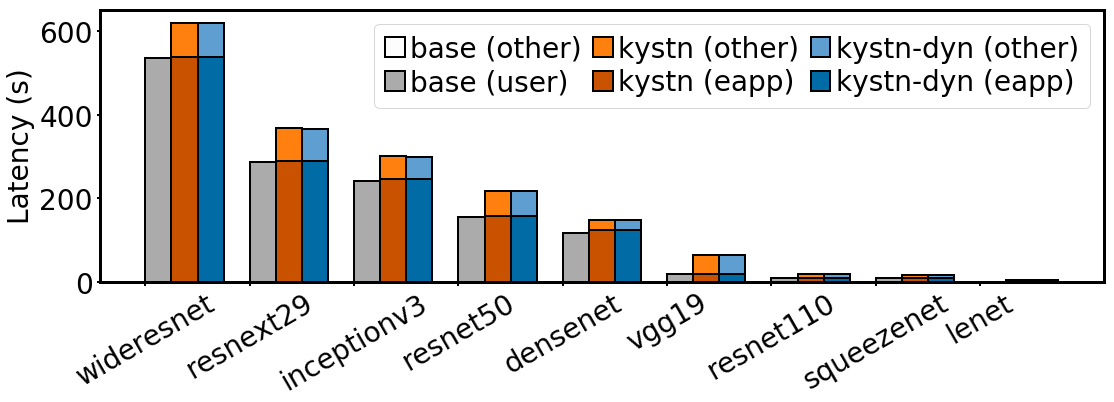

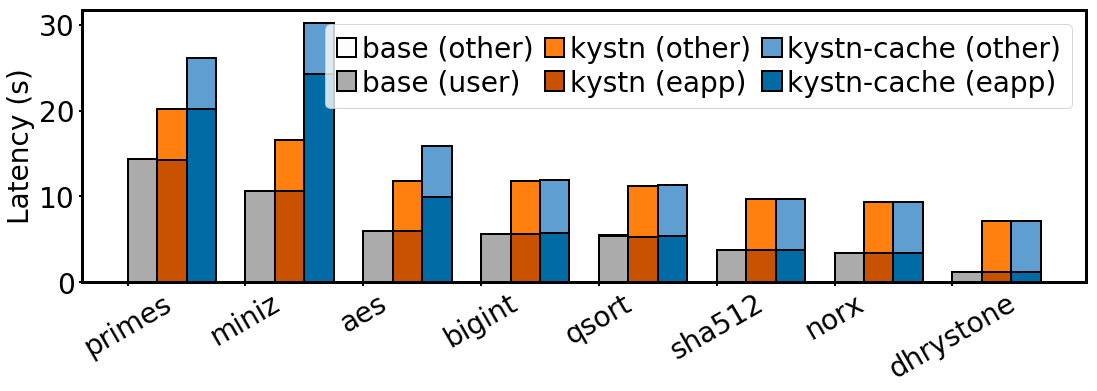

In [5]:
def draw(tmp, third):
    
    data = tmp.copy()
    data.columns = ["benchmark", "baseline_init", "baseline_run", "keystone_init", "keystone_run","%s_init"%(third,), "%s_run"%(third,)]
    data["baseline_init"] = data.baseline_init - data.baseline_run
    data["keystone_init"] = data.keystone_init - data.keystone_run
    data["%s_init"%(third,)] = data["%s_init"%(third,)] - data["%s_run"%(third,)]
    
    data = data.sort_values(["keystone_run"], ascending=False)
    
    data = data.reset_index()
    
    _alpha = 1.0
    
    plt.figure(figsize=(18,5))
    fig = plt.gcf()
    #plt = brokenaxes(ylims=((0, 100000), (1010000,1020000)), hspace=.05)
    barWidth = 0.25
    barGap = 0.0
    barHatches = ["","//////","......"]

    r1 = np.arange(len(data))
    r2 = [x + barWidth+barGap for x in r1]
    r3 = [x + barWidth+1*barGap for x in r2]
    barlabels = ["base (other)", "base (user)","kystn (other)","kystn (eapp)","kystn-%s (other)"%(third,),"kystn-%s (eapp)"%(third,)]

    #fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=_figsize,gridspec_kw = {'height_ratios':[1, 8]})

    # Create green bars (middle), on top of the firs ones
    plt.bar(r1, data["baseline_init"], 
            bottom=data["baseline_run"], 
            color=color_for_bars[0], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[0], linewidth=_linewidth, alpha=_alpha)
    # Create brown bars
    plt.bar(r1, data["baseline_run"], 
            color=color_for_bars[3], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[1], linewidth=_linewidth)

    # Create green bars (middle), on top of the firs ones
    plt.bar(r2, data["keystone_init"], 
            bottom=data["keystone_run"], 
            color=color_for_bars[1], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[2], linewidth=_linewidth, alpha=_alpha)

    # Create brown bars
    plt.bar(r2, data["keystone_run"], 
            color=color_for_bars[6], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[3], linewidth=_linewidth)

    # Create green bars (middle), on top of the firs ones
    plt.bar(r3, data["%s_init"%(third,)], 
            bottom=data["%s_run"%(third,)], 
            color=color_for_bars[5], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[4], linewidth=_linewidth, alpha=_alpha)

    # Create brown bars
    plt.bar(r3, data["%s_run"%(third,)], 
            color=color_for_bars[2], 
            edgecolor='black', 
            width=barWidth,hatch=barHatches[0],
            label=barlabels[5], linewidth=_linewidth)


    #plt.gca().barh(r1, [x for x in range(0,len(data["dyn_run"]))], 2, color="blue")

    plt.legend(loc="upper right", ncol=3,bbox_to_anchor=(1, 1.0),handlelength=0.7,handletextpad=0.2)
    plt.xticks([x - barWidth/2-5*barGap for x in r1], data.benchmark.str.replace(".O3.stripped",""), rotation=30)
    
    ax = plt.gca()
    ticks = [int(x/1000) for x in ax.get_yticks()]
    ax.set_yticklabels(ticks)
    
    plt.ylabel("Latency (s)")
    fig.savefig("benchmark-%s.pdf"%(third,), bbox_inches='tight',format="pdf")
    
    
#########################################################################################################
concat_torch = data["torch"]["noplug"].merge(data["torch"]["dyn"][["benchmark","keystone", "keystone_internal"]], left_on="benchmark", right_on="benchmark")
                          #data["torch"]["cache"][["keystone", "keystone_internal"]],
                          #data["torch"]["dyn"]],#[["keystone", "keystone_internal"]]],
                          #axis=1)
concat_rv8 = data["rv8-bench"]["noplug"].merge(data["rv8-bench"]["cache"][["benchmark","keystone", "keystone_internal"]], left_on="benchmark", right_on="benchmark")
                         #data["rv8-bench"]["cache"][["keystone", "keystone_internal"]],
                         #data["rv8-bench"]["dyn"]]#[["keystone", "keystone_internal"]]], 
                         #)

concat_rv8 = concat_rv8[concat_rv8.benchmark.str.find("O3.stripped") >= 0]
concat_torch.benchmark = concat_torch.benchmark.str.replace("app","")

draw(concat_torch, "dyn")
draw(concat_rv8, "cache")


In [5]:
invd = concat_rv8.copy()

invd["base"] = invd.base - invd.base_internal
invd["keystone_x"] = invd.keystone_x - invd.keystone_internal_x
invd["keystone_y"] = invd.keystone_y - invd.keystone_internal_y

invd["overhead_keystone"] = (invd.keystone_internal_x - invd.base_internal)/invd.base_internal * 100
invd["overhead_dyn"] = (invd.keystone_internal_y - invd.base_internal)/invd.base_internal * 100

invd["overhead_init_dyn_over_static"] = (invd.keystone_y - invd.keystone_x)/invd.keystone_x * 100
invd["overhead_run_cache_over_non_cache"] = (invd.keystone_internal_y - invd.keystone_internal_x)/invd.keystone_internal_x*100
invd["overhead_run_static_over_baseline"] = (invd.keystone_internal_x - invd.base_internal)/invd.base_internal*100
invd["overhead_run_dyn_over_baseline"] = (invd.keystone_internal_y - invd.base_internal)/invd.base_internal*100

invd.sort_values(["keystone_internal_x"], ascending=False)[["benchmark","overhead_run_static_over_baseline"]].round(2).min()


benchmark                            aes.O3.stripped
overhead_run_static_over_baseline              -1.85
dtype: object